# Single Cell Sequencing 


Uses exon data extracted from: zUMIs_output\expression\*.dgecounts.rds and gene data from: zUMIs_output\expression\*.gene_names.txt<br>
Performs quality control separately for each plate.<br>

In [1]:
# !pip install --quiet anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
import pyreadr
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import os 
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb
import sys 
import warnings
warnings.filterwarnings("ignore")
sb.set_context(context='poster')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 louvain==0.8.1 pynndescent==0.5.10


In [2]:
# define all paths for storing data
figure_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\figuresR'
output_path  = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\out'
campari_file = 'campari_scs_from_R.h5ad'
campari_file_all_genes = 'campari_scs_all_genes_from_R.h5ad'

# h5ad files with scs data
results_file_sample1 = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample1\sample1_R.h5ad'
results_file_sample2 = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample2\sample2_R.h5ad'
results_file_sample3 = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample3\sample3_R.h5ad' 
results_file_sample4 = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample4\sample4_R.h5ad' 
results_file_sample5 = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample5\sample5_R.h5ad' 


# txt file with well barcodes. the text contains the cell barcode corresponding to each position in the plate
well_barcode_sample1 = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample1\SS3_22_291.well_barcodes.txt'
well_barcode_sample2 = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample2\SS3_23_049.well_barcodes.txt'
well_barcode_sample3 = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample3\SS3_23_127.well_barcodes.txt'
well_barcode_sample4 = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample4\SS3_23_193.well_barcodes.txt'
well_barcode_sample5 = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample5\SS3_23_195.well_barcodes.txt'

# upload excel with red and green flourecence from campari (has information about position in plate and fluorecence level)
florecence_1_file_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample1\well_1_data_base.csv'
florecence_2_file_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample2\well_2_data_base.csv'
florecence_3_file_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample3\well_3_data_base.csv'
florecence_4_file_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample4\well_4_data_base.csv'
florecence_5_file_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample5\well_5_data_base.csv'

# paths to files with a list of gene ids and matching gene names (they are not the same the same for each plate!)
genes1_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample1\SS3_22_291.gene_names.txt'
genes2_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample2\SS3_23_049.gene_names.txt'
genes3_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample3\SS3_23_127.gene_names.txt'
genes4_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample4\SS3_23_193.gene_names.txt'
genes5_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\my_data\sample5\SS3_23_195.gene_names.txt'


In [3]:
# load adata file using adata library
adata1 = ad.read_h5ad(results_file_sample1)
adata2 = ad.read_h5ad(results_file_sample2)
adata3 = ad.read_h5ad(results_file_sample3)
adata3 = ad.read_h5ad(results_file_sample3)
adata4 = ad.read_h5ad(results_file_sample4)
adata5 = ad.read_h5ad(results_file_sample5)

# read gene ids and names
genes1 = pd.read_csv(genes1_path, delimiter = "\t")
genes2 =  pd.read_csv(genes2_path, delimiter = "\t")
genes3 =  pd.read_csv(genes3_path, delimiter = "\t")
genes4 =  pd.read_csv(genes4_path, delimiter = "\t")
genes5 =  pd.read_csv(genes5_path, delimiter = "\t")

# read fluorecence levels
flourecence1 = pd.read_csv(florecence_1_file_path)
flourecence2 = pd.read_csv(florecence_2_file_path)
flourecence3 = pd.read_csv(florecence_3_file_path)
flourecence4 = pd.read_csv(florecence_4_file_path)
flourecence5 = pd.read_csv(florecence_5_file_path)

# read barcodes in the same order as in the anndata object
barcodes1 = [el[0] for el in list(adata1.obs.values)]
barcodes2 = [el[0] for el in list(adata2.obs.values)]
barcodes3 = [el[0] for el in list(adata3.obs.values)]
barcodes4 = [el[0] for el in list(adata4.obs.values)]
barcodes5 = [el[0] for el in list(adata5.obs.values)]


In [4]:


# merge data base. Merge information about cell barcode and fluorecence 
#(using as common demonimator the position in the plate)
# barcode_list_sample1 = list(df_1_sample1['XC']) # from kept barcodes
well_df_sample1 = pd.read_csv(well_barcode_sample1, delimiter = "\t")
mergedRes1 = pd.merge(well_df_sample1 , flourecence1, on ='well_id')

# barcode_list_sample2 = list(df_1_sample2['XC'])
well_df_sample2 = pd.read_csv(well_barcode_sample2, delimiter = "\t")
mergedRes2 = pd.merge(well_df_sample2 , flourecence2, on ='well_id')

# barcode_list_sample3 = list(df_1_sample3['XC'])
well_df_sample3 = pd.read_csv(well_barcode_sample3, delimiter = "\t")
mergedRes3 = pd.merge(well_df_sample3 , flourecence3, on ='well_id')

well_df_sample4 = pd.read_csv(well_barcode_sample4, delimiter = "\t")
mergedRes4 = pd.merge(well_df_sample4 , flourecence4, on ='well_id')

well_df_sample5 = pd.read_csv(well_barcode_sample5, delimiter = "\t")
mergedRes5 = pd.merge(well_df_sample5 , flourecence5, on ='well_id')

In [5]:
# Perform quality control separately for all samples
sample1 = adata1
sample2 = adata2
sample3 = adata3
sample4 = adata4
sample5 = adata5

In [6]:
# make names unique
sample1.var_names_make_unique()
sample2.var_names_make_unique()
sample3.var_names_make_unique()
sample4.var_names_make_unique()
sample5.var_names_make_unique()

In [7]:
#Create a plot showing genes detected as a function of UMI counts.
def plot_counts(adata,plot_title):
    fig, ax = plt.subplots(1,3)
    x = np.asarray(adata.X.sum(axis=1))
    y = np.asarray(np.sum(adata.X>0, axis=1))
    ax[0].scatter(x, y, color="b", alpha=0.25)
    ax[0].set_ylabel("Genes Detected")
    ax[0].set_xlabel("UMI Counts")
    #ax.set_xscale('log')
    #ax.set_yscale('log')

    #histogram definition
    bins = [1500, 1500] # number of bins
    # histogram the data
    hh, locx, locy = np.histogram2d(x, y, bins=bins)
    # Sort the points by density, so that the densest points are plotted last
    z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
    idx = z.argsort()
    x2, y2, z2 = x[idx], y[idx], z[idx]

    s = ax[1].scatter(x2, y2, c=z2, cmap='viridis_r')  
    fig.colorbar(s, ax=ax)

    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel("UMI Counts")
    ax[1].set_ylabel("Genes Detected")


    expected_num_cells =  380#@param {type:"integer"}
    knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

    ax[2].loglog(knee, range(len(knee)), linewidth=5, color="g")
    ax[2].axvline(x=knee[expected_num_cells], linewidth=2, color="k")
    ax[2].axhline(y=expected_num_cells, linewidth=2, color="k")

    ax[2].set_xlabel("UMI Counts")
    ax[2].set_ylabel("Set of Barcodes")

    #plt.grid(True, which="both")
    fig.suptitle(plot_title, fontsize=16)

    fig.set_size_inches([20,3])
    plt.show()
# fig.savefig(os.path.join(figure_path , 'QC_UMI_genes_counts_pre_filtering.png'))

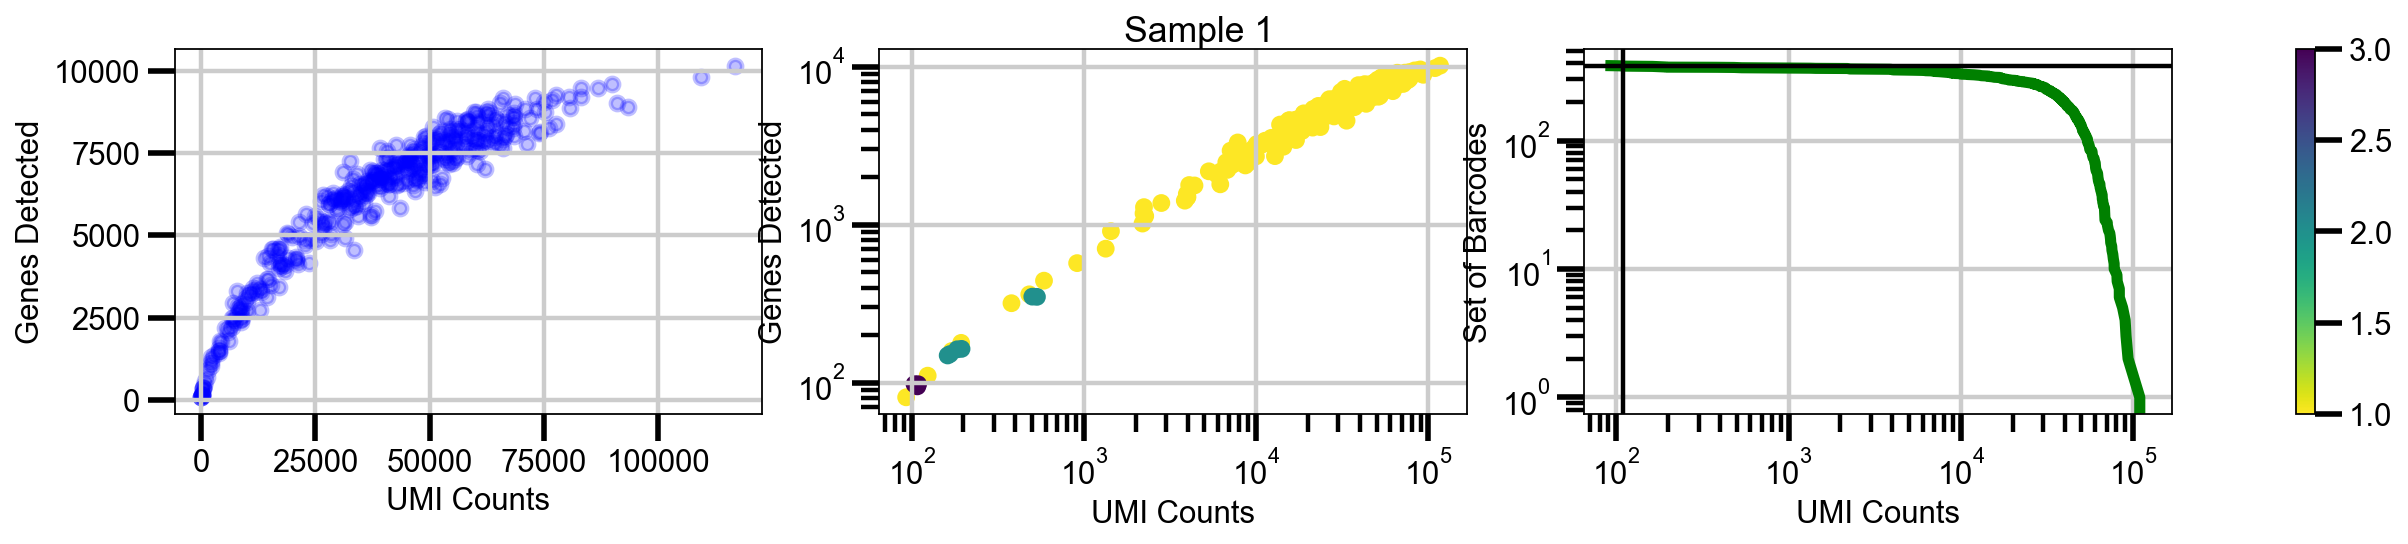

In [8]:
plot_counts(sample1,"Sample 1")

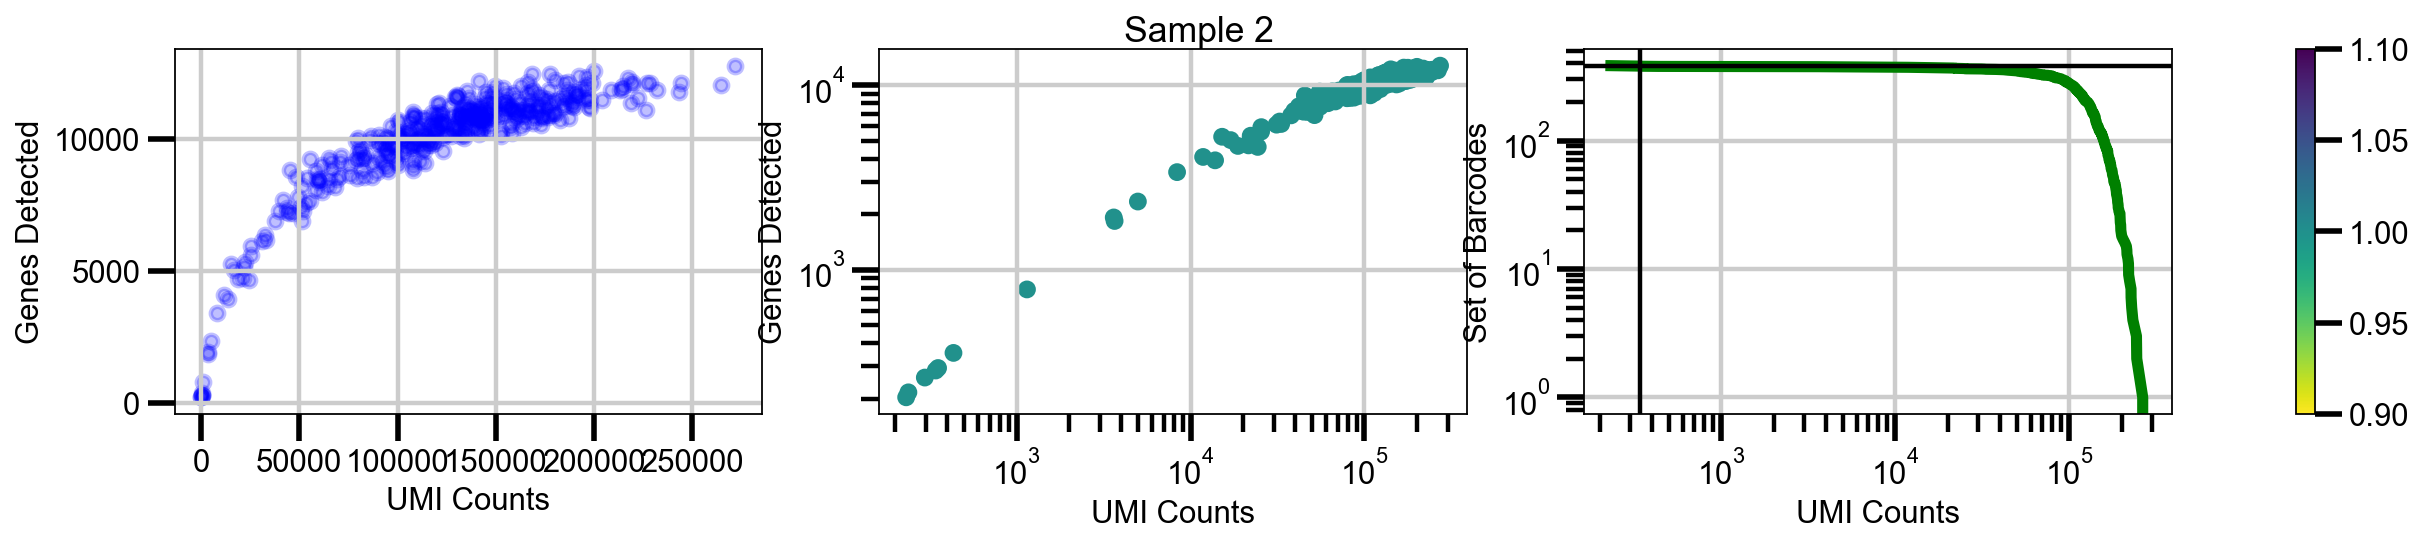

In [9]:
plot_counts(sample2,"Sample 2")

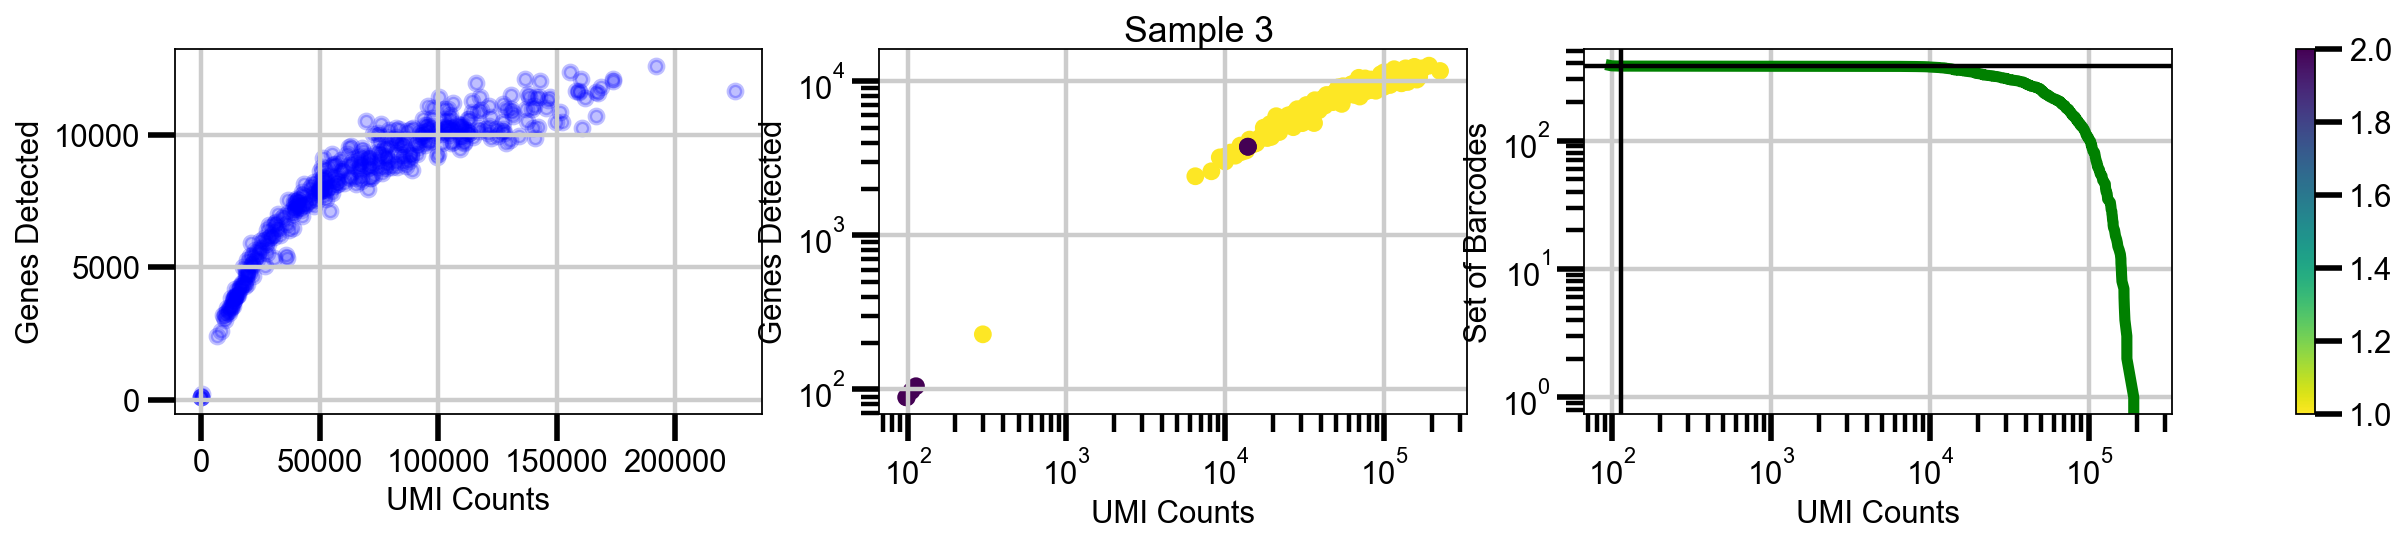

In [10]:
plot_counts(sample3,"Sample 3")

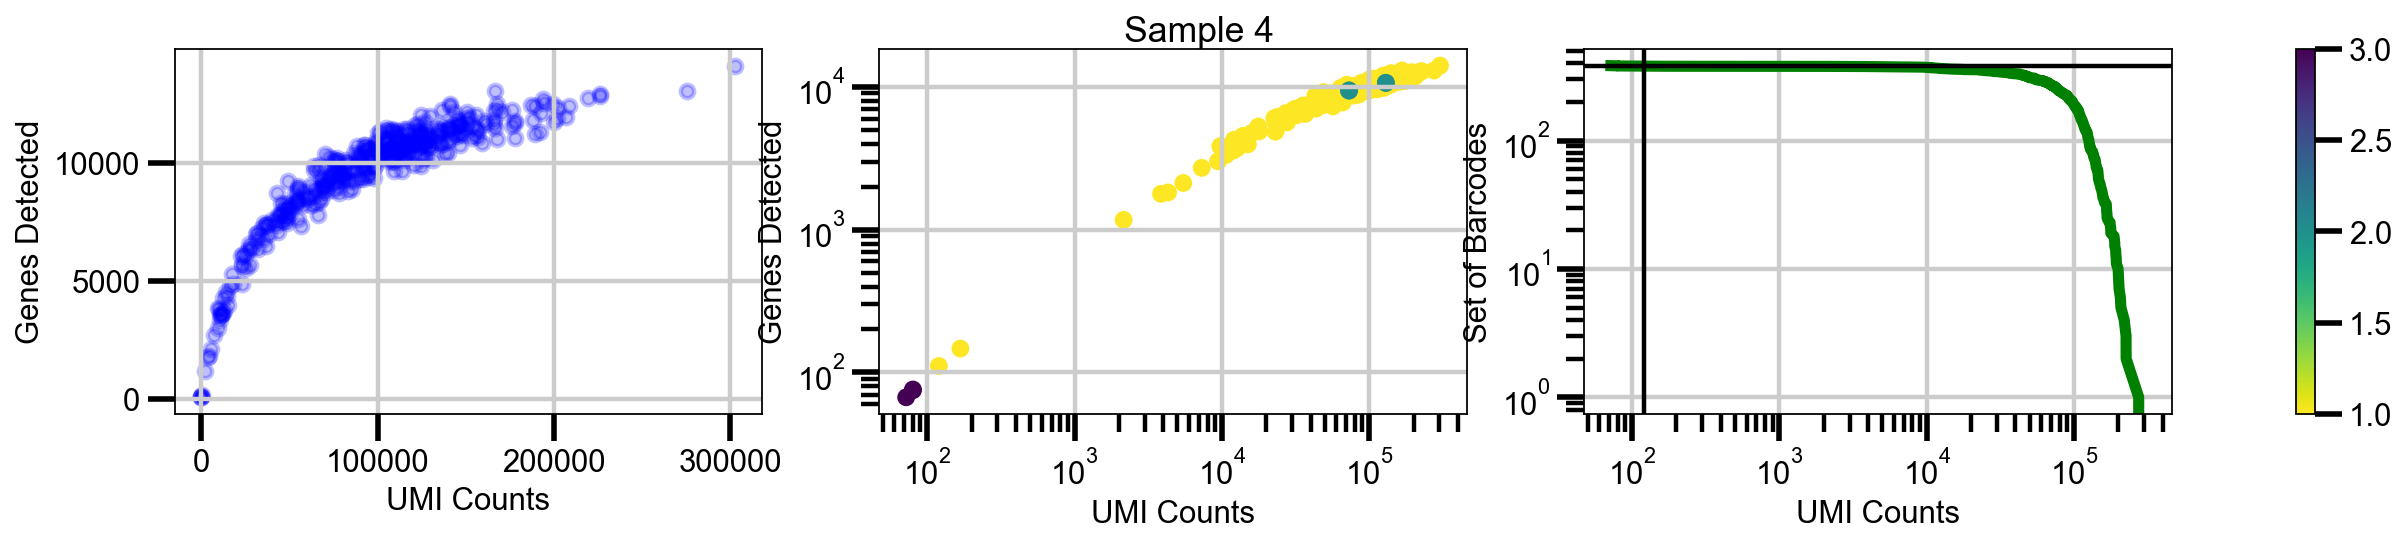

In [11]:
plot_counts(sample4,"Sample 4")

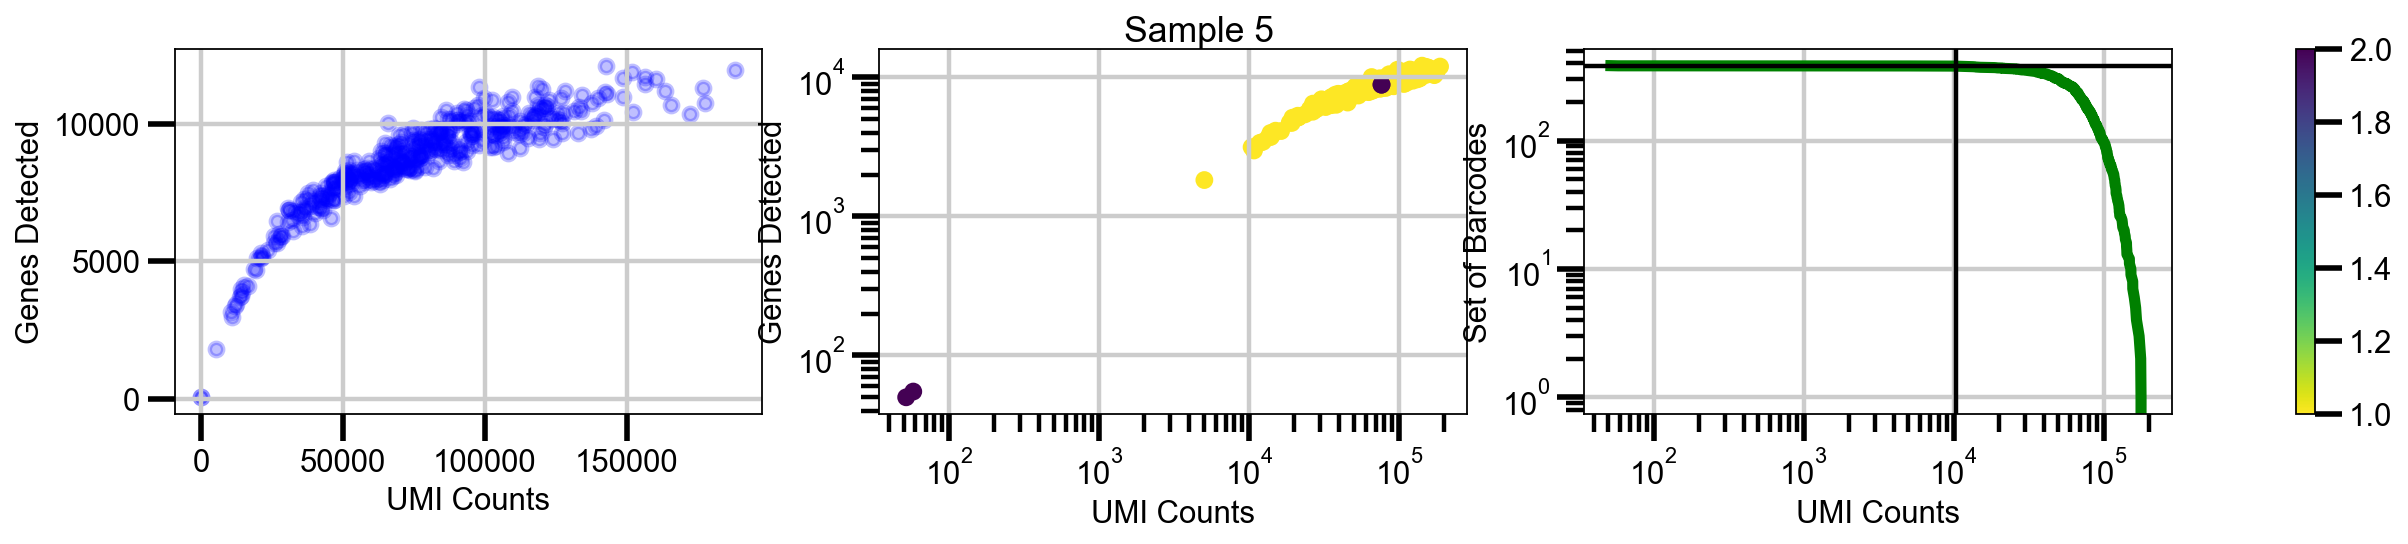

In [12]:
plot_counts(sample5,"Sample 5")

In [13]:
# takes list of gene ids and list of dataframes with id2names, returns list of matched gene names
# gene ids come from all plates now, and each plate has own file with gene names
def translate2gene_names(gene_ids,list_of_gene_files):
    cnt= 0
    gene_names = []
    for i,id in enumerate(gene_ids):
        gene = id
        for gene_list in list_of_gene_files:
            ids = gene_list["gene_id"].tolist()
            names = gene_list["gene_name"].tolist()
            if id in ids:
                idx = ids.index(id)
                gene = names[idx]
        # if after searching in all available gene files, id still not translated to name
        # use gene id as gene name
        if gene == id:
            cnt+=1
        gene_names.append(gene)
    if cnt >0:
        print(f"missing {cnt} gene names")
    return gene_names

In [14]:
# translate gene ids to names and add to anndata
gene_names1 = translate2gene_names(sample1.var["gene_id"].values,[genes1])
gene_names2 = translate2gene_names(sample2.var["gene_id"].values,[genes2])
gene_names3 = translate2gene_names(sample3.var["gene_id"].values,[genes3])
gene_names4 = translate2gene_names(sample4.var["gene_id"].values,[genes4])
gene_names5 = translate2gene_names(sample5.var["gene_id"].values,[genes5])

missing 33 gene names
missing 33 gene names
missing 33 gene names
missing 33 gene names
missing 33 gene names


In [15]:
# add gene names to anndata object
sample1.var["gene_name"] = gene_names1
sample1.var.index = sample1.var["gene_name"]

sample2.var["gene_name"] = gene_names2
sample2.var.index = sample1.var["gene_name"]

sample3.var["gene_name"] = gene_names3
sample3.var.index = sample3.var["gene_name"]

sample4.var["gene_name"] = gene_names4
sample4.var.index = sample4.var["gene_name"]

sample5.var["gene_name"] = gene_names5
sample5.var.index = sample5.var["gene_name"]

In [16]:
sample1.var['mt'] = sample1.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sample2.var['mt'] = sample2.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sample3.var['mt'] = sample3.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample3, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sample4.var['mt'] = sample4.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample4, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sample5.var['mt'] = sample5.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample5, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [17]:
sample1.var_names_make_unique()
sample2.var_names_make_unique()
sample3.var_names_make_unique()
sample4.var_names_make_unique()
sample5.var_names_make_unique()

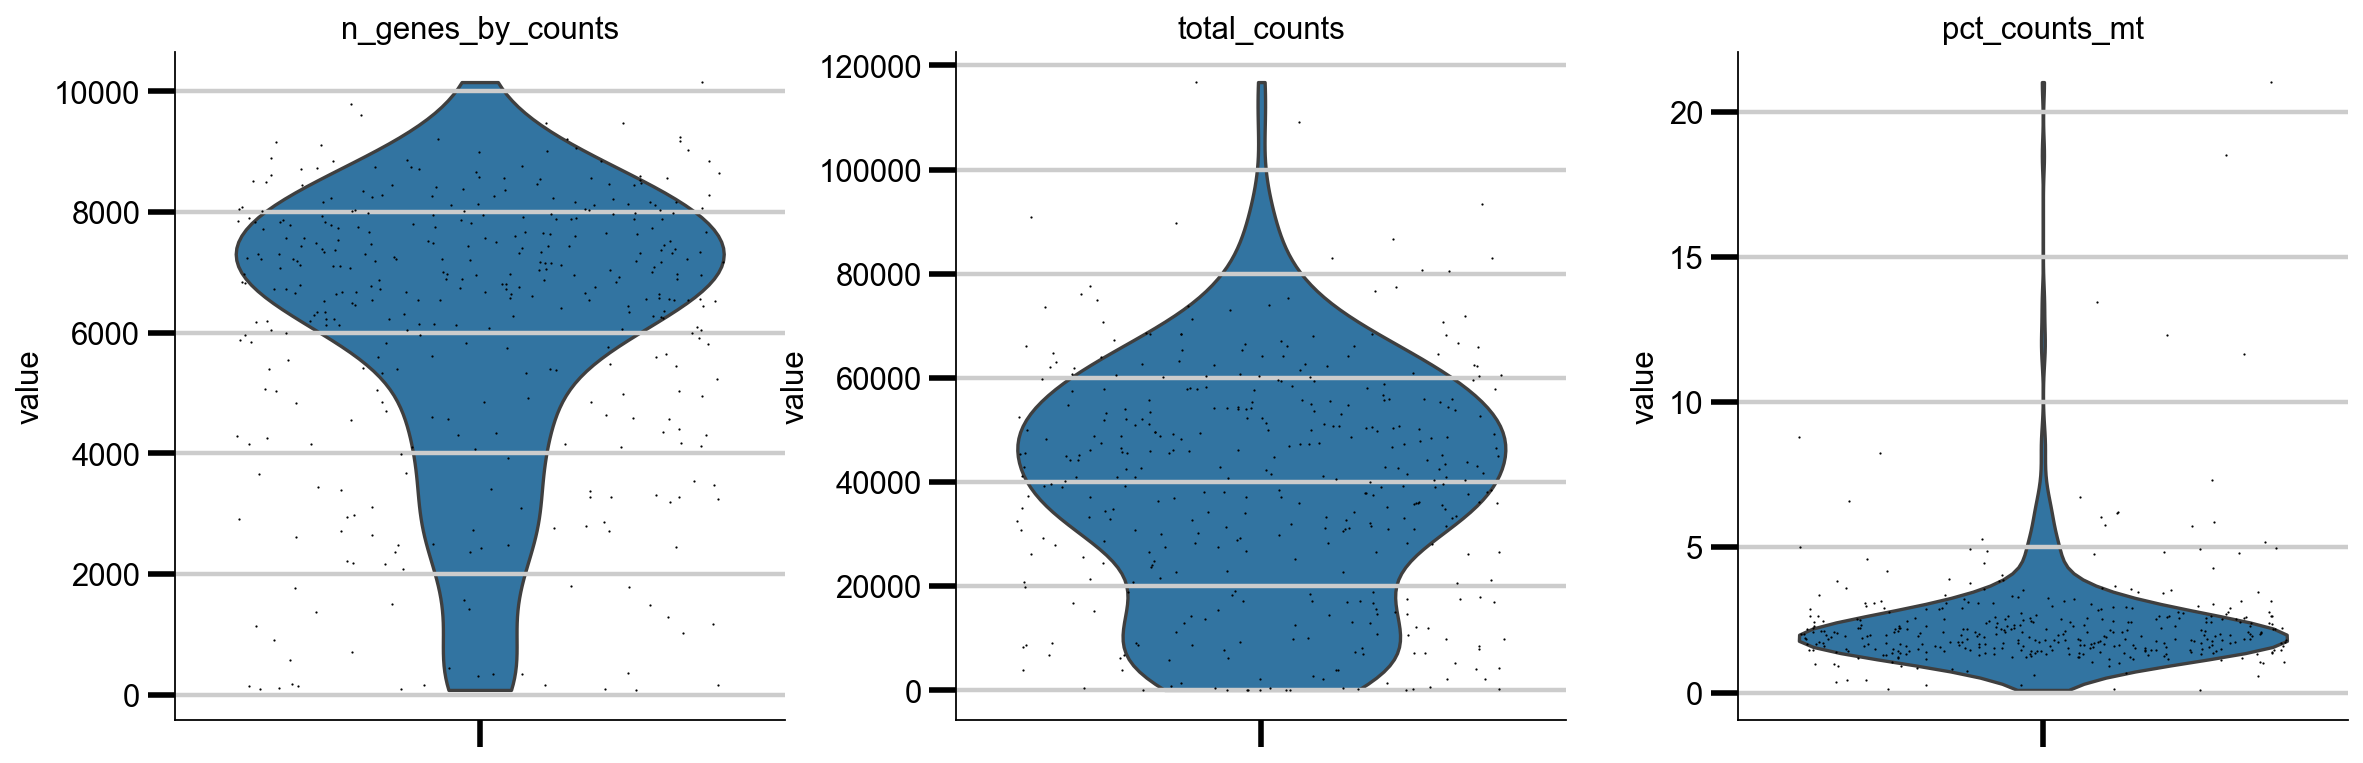

In [18]:
sc.pl.violin(sample1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

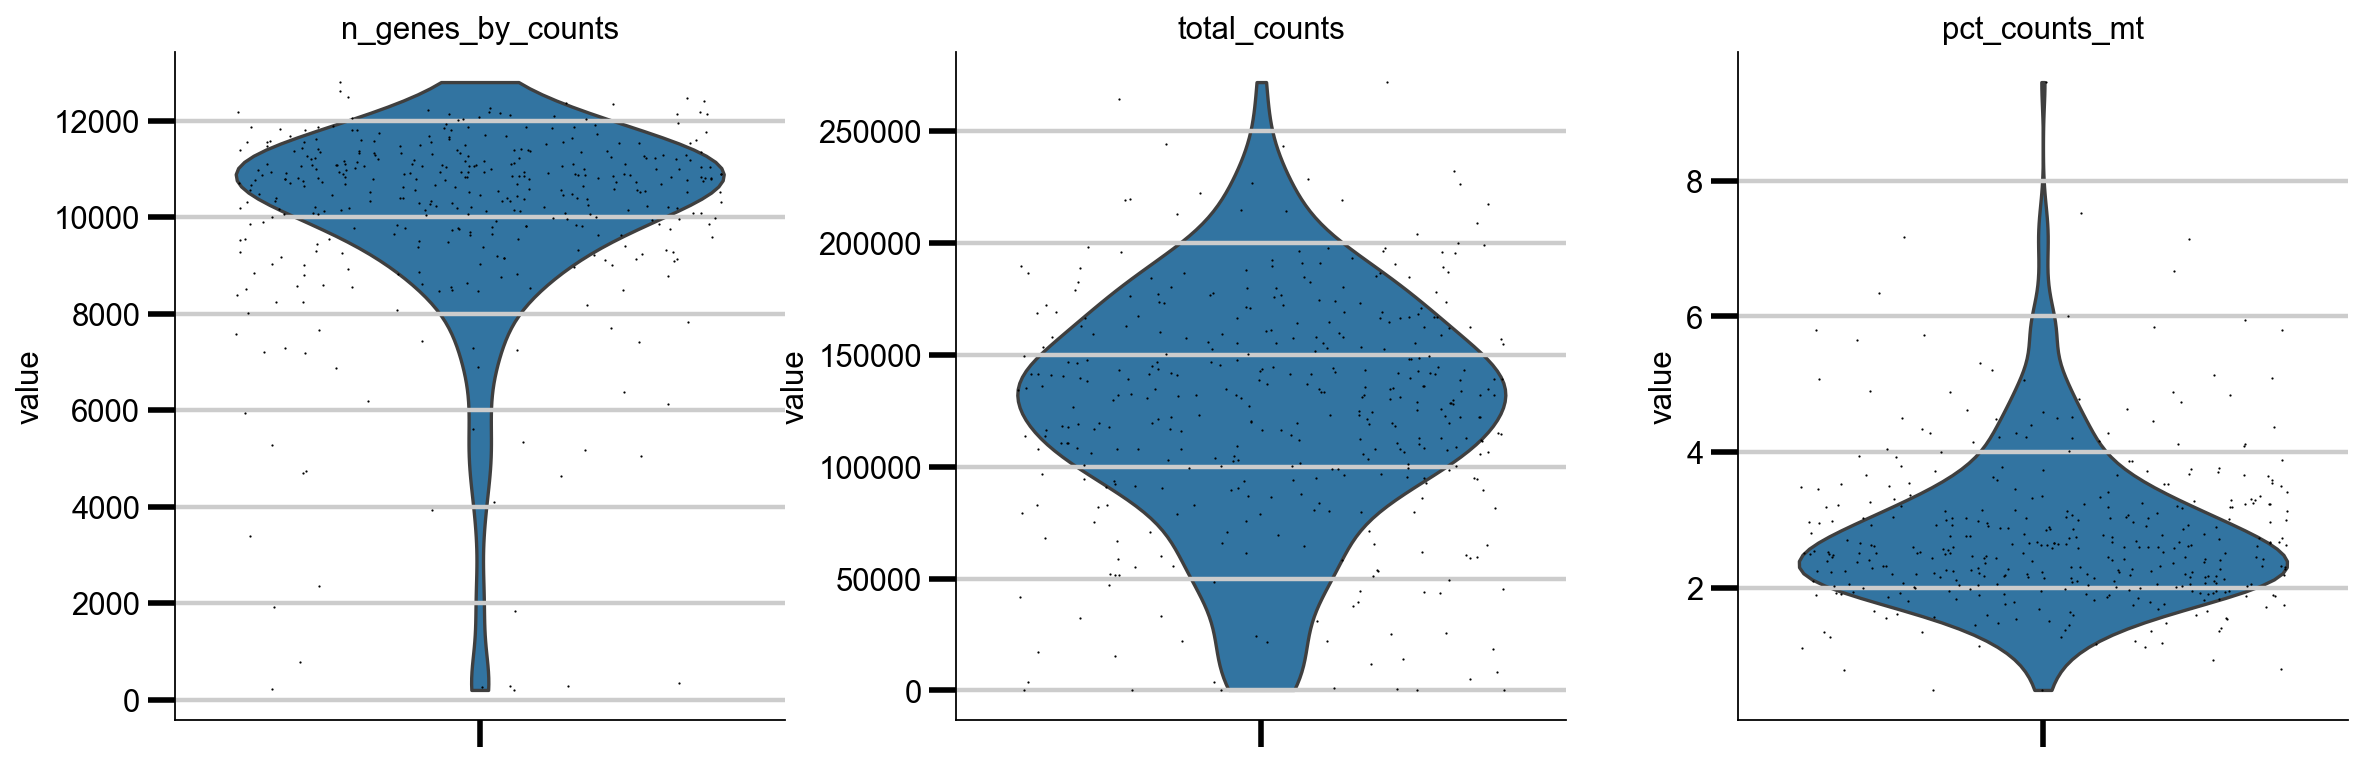

In [19]:
sc.pl.violin(sample2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

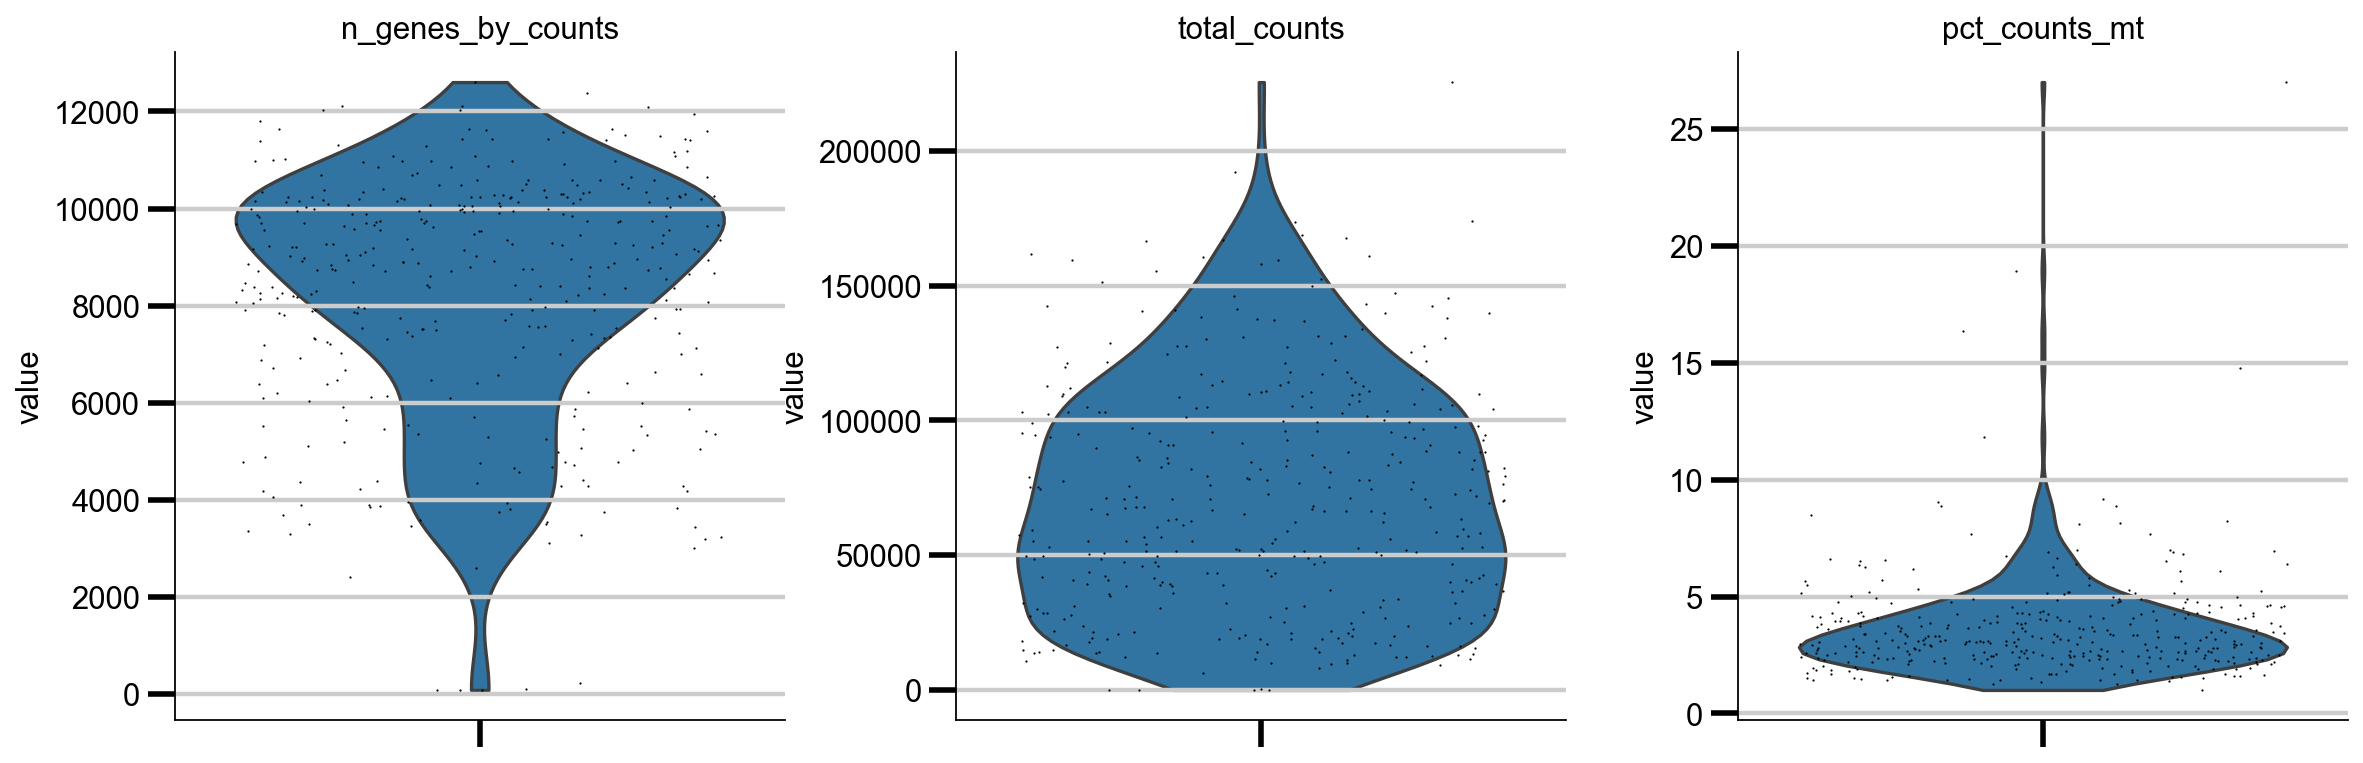

In [20]:
sc.pl.violin(sample3, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

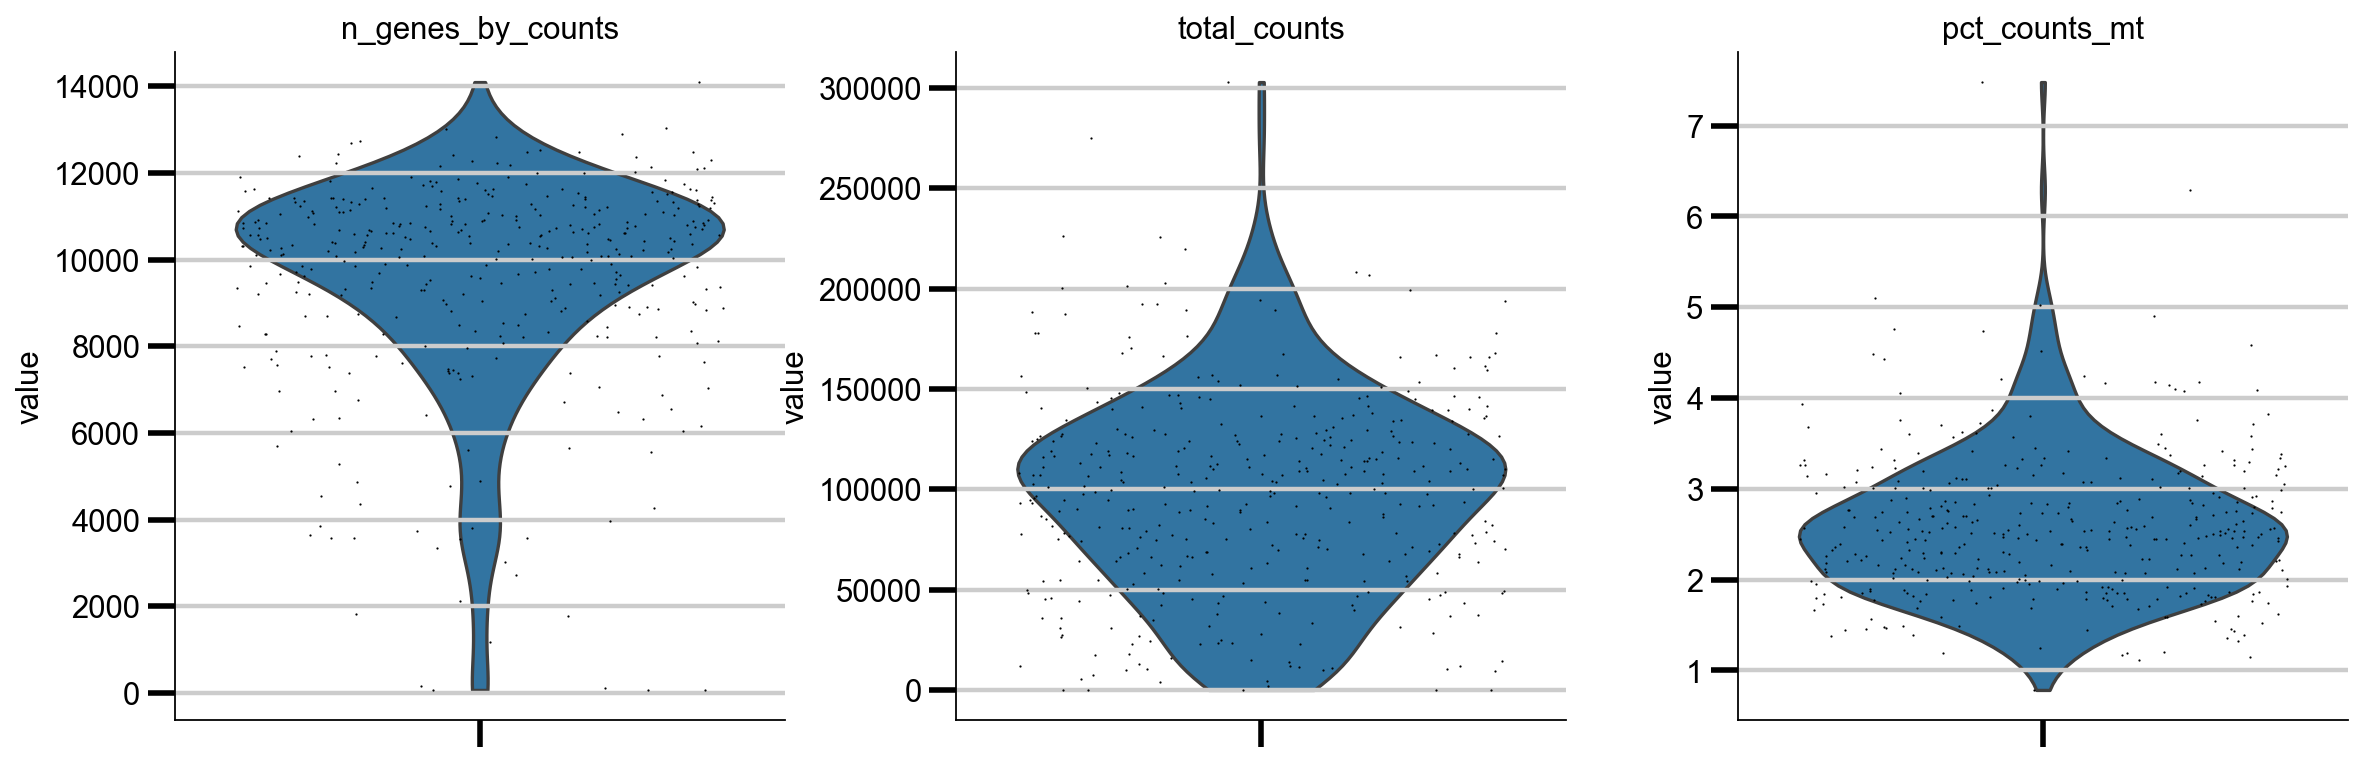

In [21]:
sc.pl.violin(sample4, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

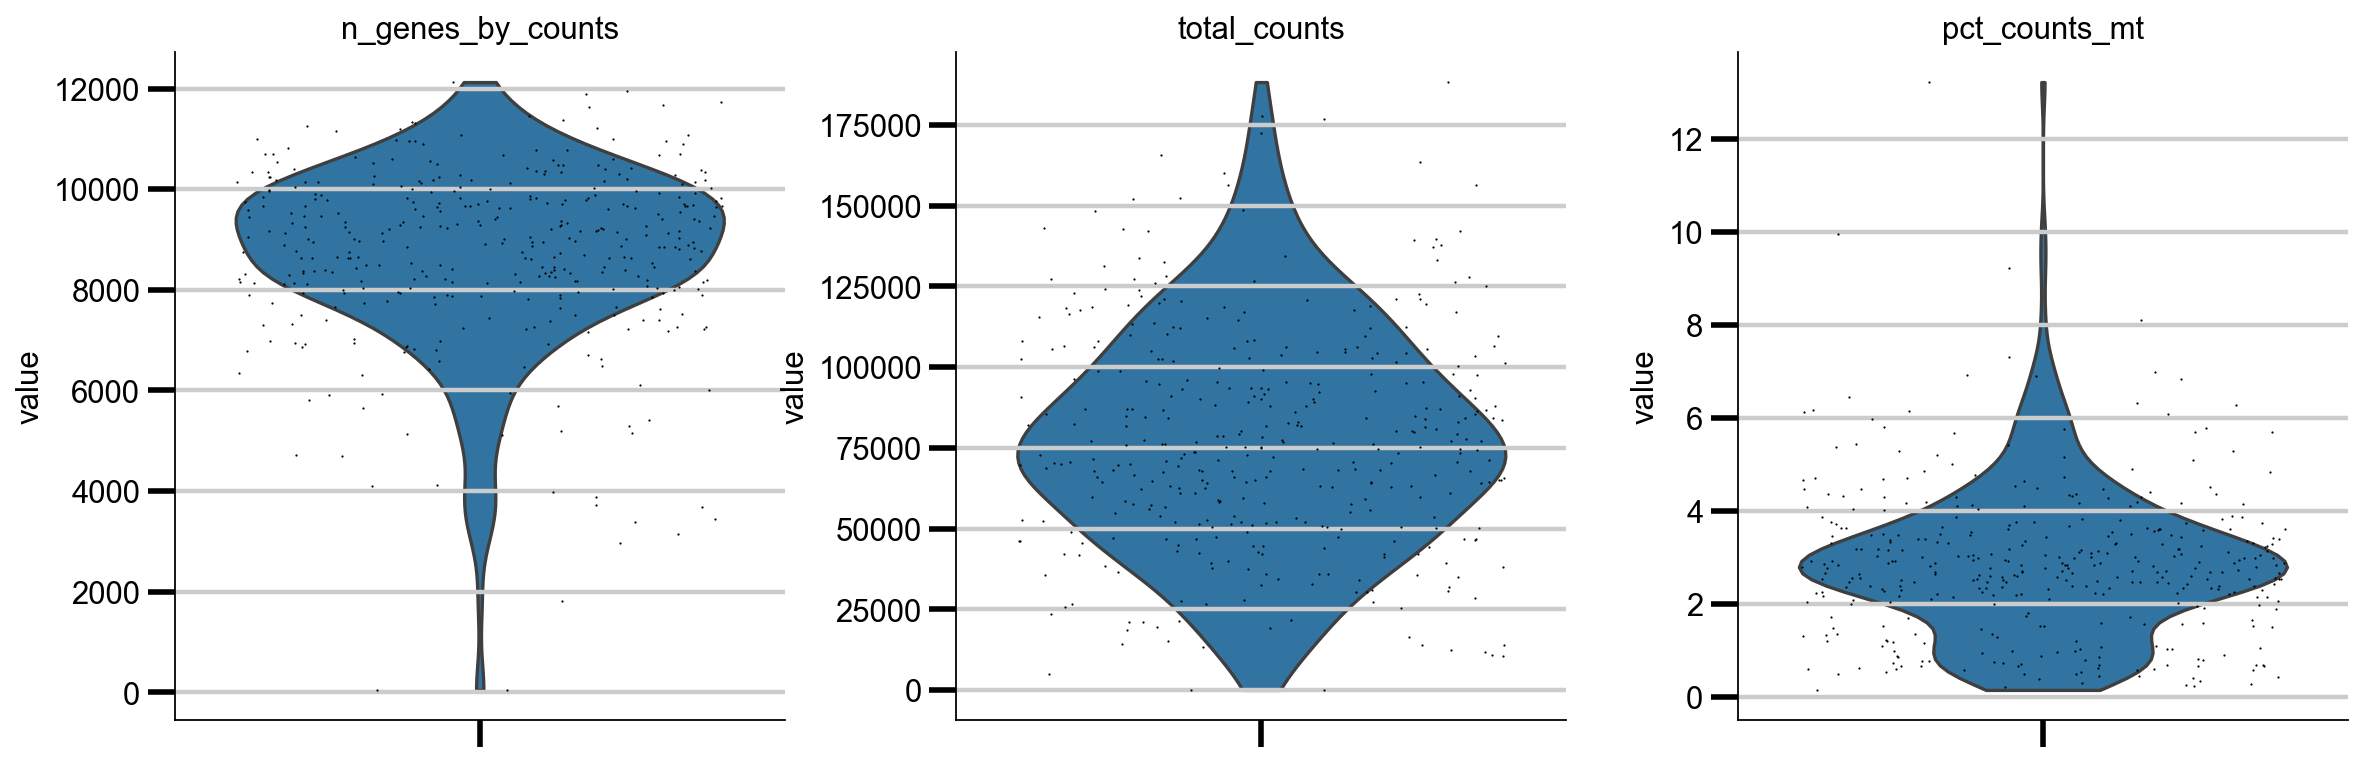

In [22]:
sc.pl.violin(sample5, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)